<a href="https://colab.research.google.com/github/yisiszhang/AdvancedPython/blob/main/colab/Lecture6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 6: Neural network II**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

#6.1 Back propagation
Continue working on the MNIST data

In [2]:
from torchvision.datasets import MNIST
random_seed = 1
torch.manual_seed(random_seed)
# load training and test sets of the MNIST dataset
mnist_train = MNIST("./data", train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ]))
mnist_test = MNIST("./data", train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ]))
print(mnist_train)
print(mnist_test)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [4]:
# set up hyperparameters
# I will talk about epochs and batch size in next class
n_epochs = 10 
batch_size_train = 100
batch_size_test = len(mnist_test) # use the entire test data
learning_rate = 0.001


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size_test, shuffle=False)
print(len(train_loader))

600


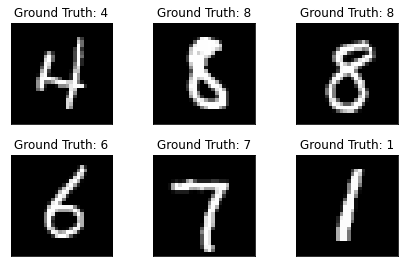

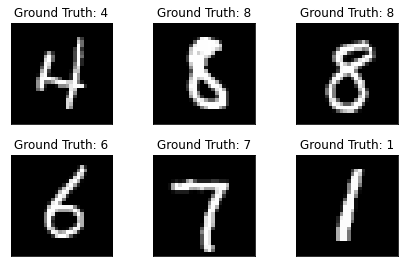

In [6]:
# plot some examples of the data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.imshow(example_data[i][0], extent = [0,1,0,1], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
# setup the neural network
class NeuralNet(nn.Module):
  # initiate a class with 3 inputs
  def __init__(self, input_size, hidden_size, num_output):
    super(NeuralNet, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, num_output)
    self.activation = nn.Sigmoid()
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    o = self.layer1(x)
    o = self.activation(o)
    o = self.layer2(o)
    #o = self.activation(o)
    return o

In [12]:
# this allows us to choose gpu computing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input size should be equal to the pixel number
input_size = mnist_train.data.shape[1] * mnist_train.data.shape[2]
# number of neurons in the hidden layer
hidden_size = 128
# number of outputs 0-9
num_output = 10
model = NeuralNet(input_size, hidden_size, num_output).to(device)

In [13]:
# choose the cost function
criterion = nn.CrossEntropyLoss()
# choose the optimization algorithm
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
# use some variables to track the performance
train_losses = []
train_counter = []
test_losses = []
# the training set is splitted into batches
nbatch = len(train_loader)
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

for epoch in range(n_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # run the forward
    outputs = model(images)
    # calculate the loss function
    loss = criterion(outputs, labels)
    # calculate the gradient
    optimizer.zero_grad()
    # backprop
    loss.backward()
    # iterate
    optimizer.step()
    if i % 100 == 0:
      # print every 100 iterations
      print('Train Epoch: {} [{} / {} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(labels), len(train_loader.dataset), 100. * i/len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(i*train_loader.batch_size + epoch*len(train_loader.dataset))

  test_loss = 0
  correct = 0
  nsample = 0
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      pred = outputs.argmax(axis=1)
      correct += (pred == labels).sum().item()
      nsample += len(labels)
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc = 100.0 * correct/nsample
  print(f'Test accuracy = {acc} %')

Train Epoch: 0 [0 / 60000 (0%)]	Loss: 2.272534
Train Epoch: 0 [10000 / 60000 (17%)]	Loss: 0.459808
Train Epoch: 0 [20000 / 60000 (33%)]	Loss: 0.573193
Train Epoch: 0 [30000 / 60000 (50%)]	Loss: 0.307677
Train Epoch: 0 [40000 / 60000 (67%)]	Loss: 0.380293
Train Epoch: 0 [50000 / 60000 (83%)]	Loss: 0.181558
Test accuracy = 93.57 %
Train Epoch: 1 [0 / 60000 (0%)]	Loss: 0.260659
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 0.165964
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 0.131507
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 0.158480
Train Epoch: 1 [40000 / 60000 (67%)]	Loss: 0.123422
Train Epoch: 1 [50000 / 60000 (83%)]	Loss: 0.143028
Test accuracy = 94.99 %
Train Epoch: 2 [0 / 60000 (0%)]	Loss: 0.151349
Train Epoch: 2 [10000 / 60000 (17%)]	Loss: 0.219851
Train Epoch: 2 [20000 / 60000 (33%)]	Loss: 0.137860
Train Epoch: 2 [30000 / 60000 (50%)]	Loss: 0.105919
Train Epoch: 2 [40000 / 60000 (67%)]	Loss: 0.165280
Train Epoch: 2 [50000 / 60000 (83%)]	Loss: 0.143880
Test accuracy = 95.89 %
Train E

Text(0, 0.5, 'negative log likelihood loss')

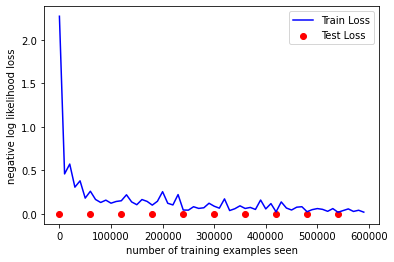

In [16]:
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')